## Business Objective

Develop a fraud analytics model that helps us (Kaspersky) detect fraud from good and normal user activity and identify precursors to the events

Process followed:


1.   Understanding the Data (Exploratory Data Analysis)
2. Data cleaning - eliminating features that are redundant
3.   Feature engineering - creating new columns based on existing that would add depth to the outcome
4. Clustering - basic clustering to determine which transactions are different than others
5. Cluster Analysis - understanding why those clusters were formed, what makes them a cluster, cluster characteristics
6. Data Engineering - transposing the data such that the fraud event becomes the target variable, and all other becomes features for the same



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Kenrich005/ISB_Datathon_23/main/Dataset_Datathon_Fraud_Detection_28122022.csv',
                 encoding= 'unicode_escape')
df.shape

(10969, 21)

In [3]:
df.head()

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,...,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
0,customer_id_0,2022-10-01 10:51:36,CHANGE_PASSWORD,RENEW,Login password recovery,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,NaN,NaN,IP differes
1,customer_id_0,2022-10-01 11:15:21,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
2,customer_id_0,2022-10-01 11:31:55,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,-205759950.0,new,old,happened on the same day,NaN,IP differes
3,customer_id_0,2022-10-01 11:45:42,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,...,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
4,customer_id_0,2022-10-03 10:28:24,DEPOSIT,100_BKO,Payment order,116820.0,1.0,False,NaN,NaN,...,iOS,iPhone,375x812,wifi,NaN,NaN,old,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10969 entries, 0 to 10968
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   10969 non-null  object 
 1   event_dttm_Deli               10969 non-null  object 
 2   event_type_nm                 10969 non-null  object 
 3   client_defined_event_type_nm  9554 non-null   object 
 4   event_desc                    10800 non-null  object 
 5   operaton_amt_100 (rupees)     10969 non-null  float64
 6   active phone call             3778 non-null   float64
 7   remote desktop protokol       3786 non-null   object 
 8   emulator                      2923 non-null   float64
 9   f                             4666 non-null   object 
 10  device_id                     3786 non-null   object 
 11  os                            3786 non-null   object 
 12  device_model                  3786 non-null   object 
 13  s

## Understanding the data
We are given with user activity history. 
Each activity is defined by 20 features. 
We see that considerable amount of data is null. 
Most importantly, we notice that we do not have a target variable. 
i.e. we do not know which activity is fraud.  

So, our foremost task then becomes to identify which transaction should be considered fraud, and have a strong backing to support it.  
Because, if our understanding of fraud transaction is incorrect, the model built therefore would also be incorrect.   
  
Let us understand each parameter one at a time

### **customer_id**

In [5]:
# Number of unique customer_id
df.customer_id.nunique()

200

In [6]:
# Number of transaction done by each customer
df.customer_id.value_counts()

customer_id_113    1430
customer_id_168    1002
customer_id_178     694
customer_id_196     219
customer_id_129     218
                   ... 
customer_id_156       4
customer_id_119       4
customer_id_137       4
customer_id_24        3
customer_id_169       3
Name: customer_id, Length: 200, dtype: int64

In [7]:
# Too huge disparity!!!
# Why some customers have just 3 transactions, while some have over 1000

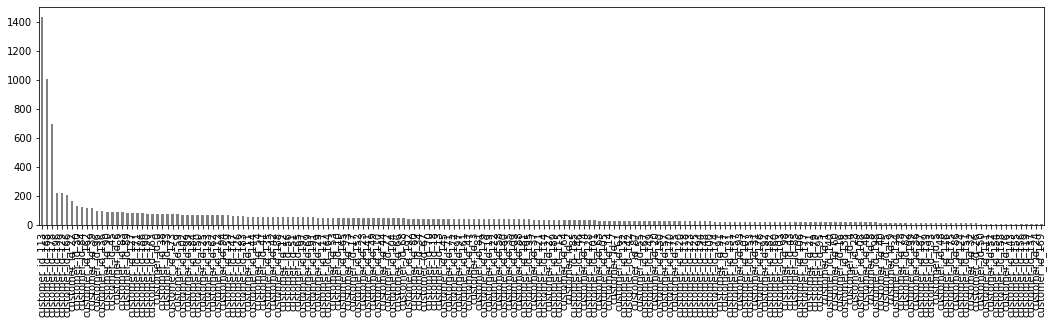

In [8]:
plt.figure(figsize=(18,4))
df.customer_id.value_counts().plot(kind='bar', color='grey');

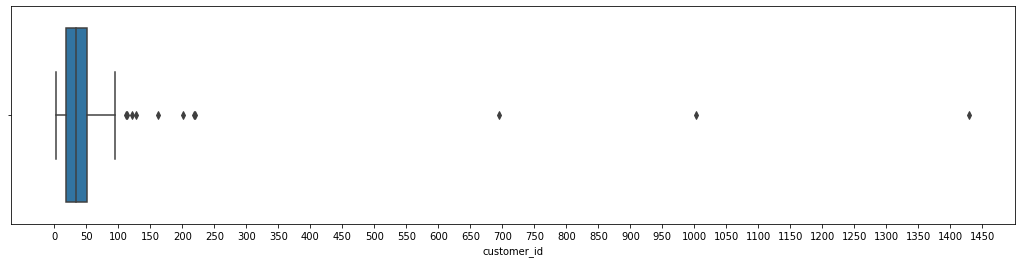

In [9]:
plt.figure(figsize=(18,4))
sns.boxplot(x=df.customer_id.value_counts())
plt.xticks(np.arange(0,1500,50));

Upon further examination, we see that only 3 customers have more than 600 events. About 75% customers have just 50 events.  
We sample one of the customers with low events to see if there is any story there.

In [10]:
df[df.customer_id=="customer_id_119"]

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,...,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
5992,customer_id_119,2022-10-18 19:26:21,SESSION_SIGNIN,NaN,Login,0.00,0.0,False,0.0,Surat,...,Android,Xiaomi M2003J15SC,1080x2110,NaN,NaN,old,old,NaN,NaN,IP differes
5993,customer_id_119,2022-10-19 12:53:32,PAYMENT,POS_PURCHASE,Purchase,177.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN
5994,customer_id_119,2022-10-19 15:29:13,PAYMENT,POS_PURCHASE,Purchase,200.60,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN
5995,customer_id_119,2022-10-20 16:18:08,PAYMENT,POS_PURCHASE,Purchase,376.42,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,old,NaN,NaN,NaN


### **event_dttm_Deli**

In [11]:
# Number of unique event_dttm_Deli
df.event_dttm_Deli.nunique()

10837

In [12]:
# Converting to datetime format
df.event_dttm_Deli = pd.to_datetime(df.event_dttm_Deli)

# Start Datetime
min(df.event_dttm_Deli)

Timestamp('2022-09-22 17:43:37')

In [13]:
# End Datetime
max(df.event_dttm_Deli)

Timestamp('2022-11-23 19:53:06')

In [14]:
# Datetime Range
max(df.event_dttm_Deli) - min(df.event_dttm_Deli)

Timedelta('62 days 02:09:29')

In [15]:
df['day_of_week'] = df['event_dttm_Deli'].dt.day_name()
df['day_of_week'].value_counts()

Saturday     1759
Monday       1754
Wednesday    1592
Thursday     1570
Tuesday      1538
Friday       1514
Sunday       1242
Name: day_of_week, dtype: int64

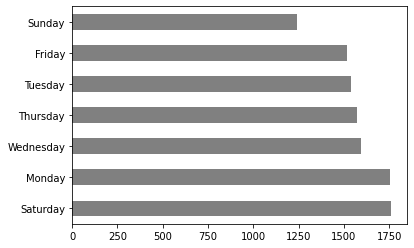

In [16]:
df.day_of_week.value_counts().plot(kind='barh', color='grey');

Monday and Saturday have more events than other days, Sunday being the least.  
Since we don't have the target variable yet, we are unable to see the significance of this feature.

In [17]:
df['hour'] = df['event_dttm_Deli'].dt.hour
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df['session'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)
df['session'].value_counts()

Noon             3022
Morning          2728
Eve              2686
Early Morning    1128
Night             703
Late Night        702
Name: session, dtype: int64

### **event_type_nm**

In [18]:
# Number of unique event_type_nm
df.event_type_nm.nunique()

15

In [19]:
df.event_type_nm.value_counts()

PAYMENT                  6387
SESSION_SIGNIN           2630
CLIENT_DEFINED            373
WITHDRAW                  336
DEPOSIT                   332
CHANGE_PASSWORD           269
CHECK                     207
CHANGE_ALERT_SETTINGS     149
VIEW_STATEMENT            100
REQUEST_CREDIT             70
CARD_PIN_CHANGE            53
REQUEST_NEW_CARD           24
USER_DETAILS               19
UPDATE_USER                19
ADD_PAYEE                   1
Name: event_type_nm, dtype: int64

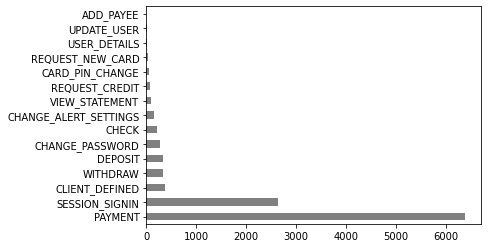

In [20]:
df.event_type_nm.value_counts().plot(kind='barh', color='grey');

Payment and Session Signin are the most occuring events. We want to focus on these two events we want to identify fraudulent payments; suspicious session_signin becomes the precursor for the fraud.

### **client_defined_event_type_nm**

In [21]:
# Number of unique client_defined_event_type_nm
df.client_defined_event_type_nm.nunique()

100

In [22]:
df.client_defined_event_type_nm.value_counts()

POS_PURCHASE                   3807
MOB_APP_SESSION_SIGNIN         1088
POS_P2P_DEBIT                   535
POS_PRE_PURCHASE                305
C2C_REQUEST                     271
                               ... 
Construction                      1
CASH                              1
POS                               1
ACCEPT_AUTOPAYMENT_M2M            1
VIRTUAL_CREDIT_CARD_MOB_APP       1
Name: client_defined_event_type_nm, Length: 100, dtype: int64

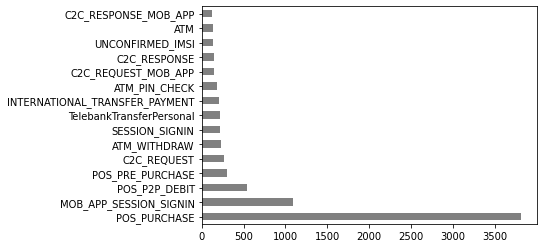

In [23]:
df.client_defined_event_type_nm.value_counts().nlargest(15).plot(kind='barh', color='grey');

"Point of Sale PURCHASE" has the highest transactions (3807).  
Can fraud happen at Point of Sale?  
Someone could steal and use your card at the POS. And several cards do not require pin for transactions, making it easier for fraud.

### event_desc

In [24]:
# Number of unique event_desc
df.event_desc.nunique()

76

In [25]:
df.event_desc.value_counts()

Purchase                                                             3807
Login                                                                2630
Debit part of P2P transfer via POS                                    535
Initial C2C request outgoing (C01 Message 477)                        419
Secondary request C2C outgoing (C02 Message 291)                      364
                                                                     ... 
Replenishment of a brokerage account                                    1
Creating a new template. Transfers within the bank to individuals       1
Secondary request C2C outgoing Me2Me                                    1
Primary request C2C outgoing Me2Me                                      1
Cash withdrawal from Profile plastic card - rupees                      1
Name: event_desc, Length: 76, dtype: int64

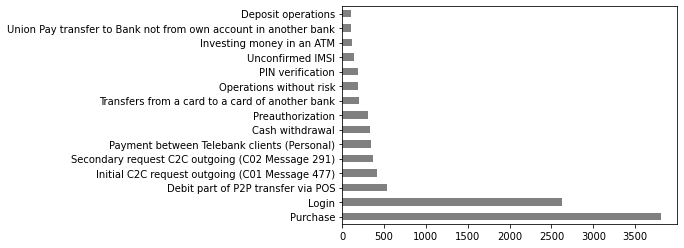

In [26]:
df.event_desc.value_counts().nlargest(15).plot(kind='barh', color='grey');

Naturally, fraud happens to make monetary transaction, a.k.a purchases. Rarely does one commit fraud to get personal details. We want to see what purchases can be considered as fraud. Purchase by itself isn't a fraud. But if someone consistently spends frugally, and then suddenly spends a whopping amount, it may be flagged suspicious.  
We do not have what the person was purchasing. That would have added another dimension to the analysis, but for now, the purchase amount is the clue.

### operaton_amt_100 (rupees)

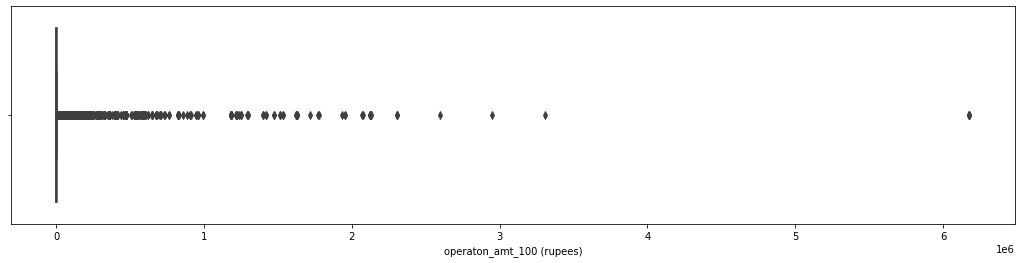

In [27]:
# Continuous variable - boxplot, histplot

plt.figure(figsize=(18,4))
sns.boxplot(x=df['operaton_amt_100 (rupees)']);
# plt.xticks(np.arange(0,1500,50));

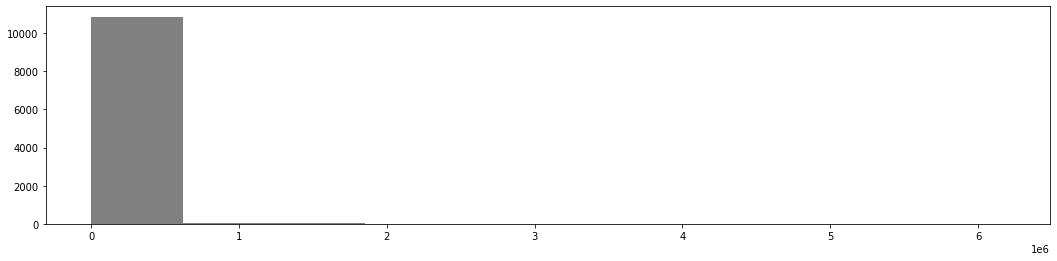

In [28]:
plt.figure(figsize=(18,4))
plt.hist(df['operaton_amt_100 (rupees)'], color='grey');

### active phone call

In [29]:
# Number of unique values
df['active phone call'].unique()

array([nan,  1.,  0.])

In [30]:
# Value counts of each category
df['active phone call'].value_counts(dropna=False)

NaN    7191
0.0    3552
1.0     226
Name: active phone call, dtype: int64

In [31]:
df['active phone call str'] = df['active phone call'].astype('str')

In [32]:
df.groupby(['event_type_nm','active phone call str']).size().unstack()

active phone call str,0.0,1.0,nan
event_type_nm,,,
ADD_PAYEE,1.0,NaN,NaN
CARD_PIN_CHANGE,38.0,NaN,15.0
CHANGE_ALERT_SETTINGS,7.0,2.0,140.0
CHANGE_PASSWORD,164.0,5.0,100.0
CHECK,NaN,NaN,207.0
CLIENT_DEFINED,228.0,11.0,134.0
DEPOSIT,41.0,1.0,290.0
PAYMENT,1062.0,33.0,5292.0
REQUEST_CREDIT,29.0,17.0,24.0


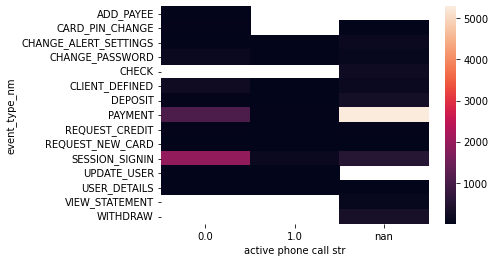

In [33]:
sns.heatmap(df.groupby(['event_type_nm','active phone call str']).size().unstack());

Active Phone calls are mostly happening in two instances - Session signin and Payment. It is common that tele scammers call unsuspecting targets and trick them to give access to their computer. 

### **Remote Desktop Protocol**

In [34]:
# Unique values in this feature
df['remote desktop protokol'].unique()

array([nan, False, True], dtype=object)

In [35]:
df['remote desktop protokol'].value_counts(dropna=False)

NaN      7183
False    3768
True       18
Name: remote desktop protokol, dtype: int64

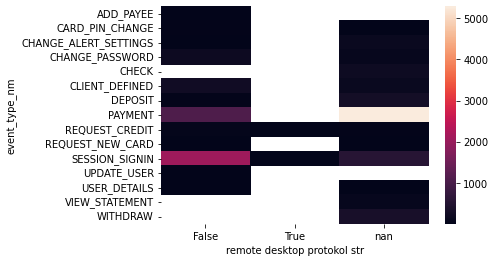

In [36]:
df['remote desktop protokol str'] = df['remote desktop protokol'].astype('str')
sns.heatmap(df.groupby(['event_type_nm','remote desktop protokol str']).size().unstack());

Similar story here as that of active phone call. One may say if we have active phone call, and remote desktop activated, it is 90% someone being scammed to give credit info.

### **emulator**

In [37]:
# Unique values in this feature
df['emulator'].unique()

array([ nan,   0., 322.])

What is an emulator?  
An emulator is a hardware device or software program that enables one computer system (also known as a host) to imitate the functions of another computer system (known as the guest). It enables the host system to run software, tools, peripheral devices and other components which are designed for the guest system. Emulators can be of different types, replicating things such as hardware, software, OS or CPU. However, in most cases hardware architecture is emulated to provide an environment similar to a guest system.

Source: https://www.techopedia.com/definition/4788/emulator

Scammer often use emulator to mask targets' computer screens and apply scare tactics such as deleting all folders and files of their PC. Emulator is mostly used in conjunction with remote desktop control. Let's check the same.

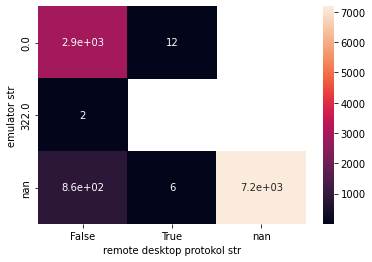

In [38]:
df['emulator str'] = df['emulator'].astype('str')

sns.heatmap(df.groupby(['emulator str','remote desktop protokol str']).size().unstack(),annot=True);

We were wrong. Looks like emulator has not much to do with RDP, at least for this data sample.

### **f**

In [39]:
# Nuumber of unique values in this feature
df['f'].nunique()

82

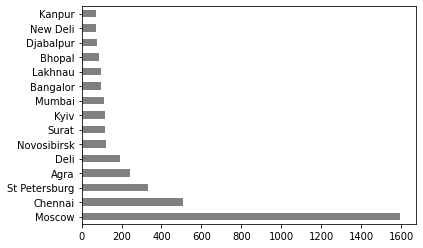

In [40]:
df.f.value_counts().nlargest(15).plot(kind='barh', color='grey');

82 is too big a list/category. We need to somehow reduce the category for machine to make meaning of it.  
One way would be to segment it by country instead of city.  
The cities above mostly seem to be from India or Russia.  
This seems to be the city where the transaction/event took place.  
Is it strange that most transactions are from one city?  
As in don't people from all cities engage in banking transactions?  
 

In [41]:
country_dict = {'St Petersburg':'Russia','Moscow':'Russia','Novosibirsk':'Russia','Oslo':'Russia','Vladikavkaz':'Russia','Tula':'Russia',
                'Puna':'India','Khaidarabad':'India','Surat':'India','Kalkutta':'India','Lakhnau':'India','New Deli':'India','Kanpur':'India','Deli':'India','Mumbai':'India',
                'Nagpur':'India','Chennai':'India','Bangalor':'India','Akhmadabad':'India','Mirzapur':'India','Jaipur':'India', 'Thana':'India','Gaziabad':'India',
                'Bhopal':'India','Indaur':'India','Vadodara':'India','Agra':'India','Dhanbad':'India','Srinagar':'India','Djabalpur':'India','Aligahr':'India',
                'Khaora':'India','Gvalior':'India','Tashkent':'Uzbekistan','Tbilisi':'Georgia',"K'alak'i T'bilisi":'Georgia',
                'Amsterdam':'Netherlands','Paris':'France','Soran':'Iraq','Frankfurt am Main':'Germany','Antalya':'Turkey','Tallinn':'Estonia','Stockholm':'Sweden',
                'Belgrad':'Serbia','Dubai':'UAE','Sharjah':'UAE','Ras al-Khaimah':'UAE','Naaldwijk':'Netherlands','Maykop':'Russia','Vladivostok':'Russia',
                'London':'UK','Surgut':'Russia','New York':'USA','Vienna':'Austria','Petrozavodsk':'Russia','Prague':'Czech Republic','Kirishi':'Russia','Warsaw':'Poland',
                'Budapest':'Hungary','Navi Mumbai':'India','Grozny':'Russia','Minsk':'Belarus',"Kamensk-Ural'skiy":'Russia','Gunzenhausen':'Germany','TDeli':'India',
                'Aleksandrov':'Russia','Manassas':'USA','Chicago':'USA','Hillsboro':'USA','Newark':'USA','Las Vegas':'USA','Bucharest':'Romania','Kirov':'Russia',
                'New Deli Oblast':'India','Yaroslavl':'Russia','Shadrinsk':'Russia','Kostroma':'Russia','Ryazan':'Russia','Tikhoretsk':'Russia','Volgograd':'Russia',
                'Cedar Knolls':'USA','Kyiv':'Ukraine'}

In [42]:
df['country'] = df['f'].map(country_dict)  
df['country'].value_counts()

India             2217
Russia            2203
Ukraine            116
USA                 26
UK                  21
Georgia             11
Sweden              10
Serbia              10
France               9
UAE                  9
Poland               8
Germany              6
Netherlands          4
Iraq                 4
Belarus              3
Czech Republic       2
Romania              2
Turkey               1
Estonia              1
Uzbekistan           1
Austria              1
Hungary              1
Name: country, dtype: int64

In [43]:
df['country'].nunique()

22

Reduction to 22 categories from 82, not bad, but is there any business or statistical sense to this?  
As in does country have any impact on fraud likeliness?  
May need to further group the countries to India, Russia, Ukraine and others.  

In [44]:
df['country'] = np.where((df['country'].isin(['India','Russia'])|df.country.isnull()),df['country'],'Other')
df['country'].value_counts()

India     2217
Russia    2203
Other      246
Name: country, dtype: int64

In [45]:
df.shape

(10969, 28)

### **Device ID**

In [46]:
# Number of unique device_id(s)
df.device_id.nunique()

211

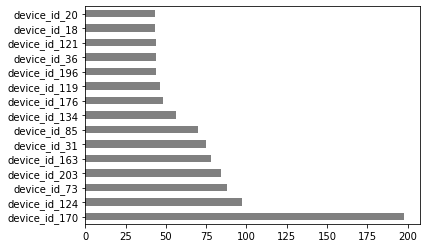

In [47]:
df.device_id.value_counts().nlargest(15).plot(kind='barh', color='grey');

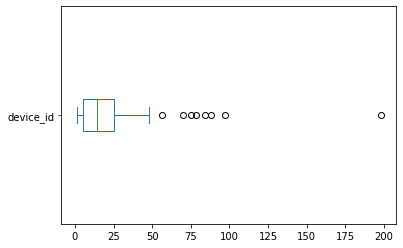

In [48]:
df.device_id.value_counts().plot(kind='box',vert=False);

In [49]:
df.device_id.value_counts().describe()

count    211.000000
mean      17.943128
std       20.745317
min        1.000000
25%        5.000000
50%       14.000000
75%       25.000000
max      198.000000
Name: device_id, dtype: float64

75% of all the device ids were used less than 25 times.  
But could device_id have any bearing on probability of fraud? Highly unlikely.  
Also considering that we have 211 unique device ids (read categories), the dimensionality becomes very high.  
One hot encoding on this would make 200 columns. Curse of dimensionality!  
This feature is recommended to be removed.

### **os**

In [50]:
# Number of unique operating system
df.os.nunique()

3

In [51]:
# How frequent is each OS
df.os.value_counts()

Android    2923
iOS         858
iPadOS        5
Name: os, dtype: int64

In [52]:
# iPadOS should be clubbed with iOS since both have the same parent
df.os = df.os.replace('iPadOS','iOS')
df.os.value_counts()

Android    2923
iOS         863
Name: os, dtype: int64

In [53]:
df.os.value_counts('a')

Android    0.772055
iOS        0.227945
Name: os, dtype: float64

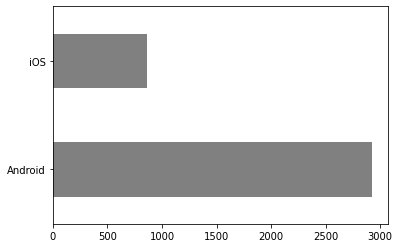

In [54]:
df.os.value_counts().plot(kind='barh', color='grey');



iOS was used just 23% of the time, while Android was used 77% of the time.  
Intuition says that Android has a much higher probability of fraud than does iOS.

### **device_model**

In [55]:
df.device_model.nunique()

114

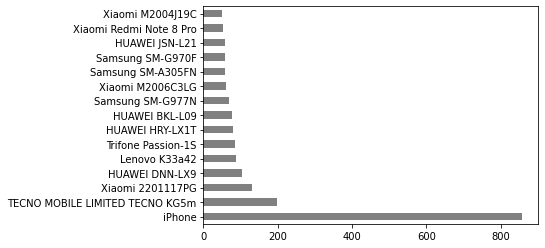

In [56]:
df.device_model.value_counts().nlargest(15).plot(kind='barh', color='grey');

In [57]:
df['model_name'] = df.device_model.str.split(' ').str[0]

df.model_name.value_counts()

iPhone        858
Xiaomi        837
Samsung       709
HUAWEI        546
TECNO         236
Lenovo         88
Trifone        84
Asus           59
Google         50
Realme         48
INFINIX        44
Vivo           38
ONEPLUS        31
Cherry         28
10.or          22
OnePlus        21
Proscan        16
TP-Link        15
Blackview      15
ZTE            10
ASUS_Z01QD     10
Meizu           9
DEXP            6
iPad            5
UMIDIGI         1
Name: model_name, dtype: int64

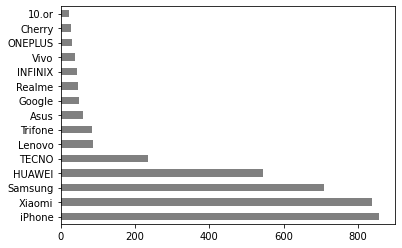

In [58]:
df.model_name.value_counts().nlargest(15).plot(kind='barh', color='grey');

In [59]:

df.columns

Index(['customer_id', 'event_dttm_Deli', 'event_type_nm',
       'client_defined_event_type_nm', 'event_desc',
       'operaton_amt_100 (rupees)', 'active phone call',
       'remote desktop protokol', 'emulator', 'f', 'device_id', 'os',
       'device_model', 'screensize', 'agentconnectiontype', 'screen_hash',
       'device for user', 'reciever', 'password change', 'fast change of ip',
       'ip not equal to previous', 'day_of_week', 'hour', 'session',
       'active phone call str', 'remote desktop protokol str', 'emulator str',
       'country', 'model_name'],
      dtype='object')

In [60]:
df['model2'] = np.where((df['model_name'].isin(['iPhone','Xiaomi','Samsung','HUAWEI','TECNO'])|df.model_name.isnull()),df['model_name'],'Other')
df['model2'].value_counts()

iPhone     858
Xiaomi     837
Samsung    709
Other      600
HUAWEI     546
TECNO      236
Name: model2, dtype: int64

### **screensize**

In [61]:
df.screensize.nunique()

92

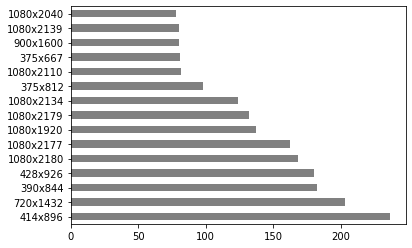

In [62]:
df.screensize.value_counts().nlargest(15).plot(kind='barh', color='grey');

Too many features to draw any significant insights from. We see here that 414 x 896 have relatively higher events. That is simply because that is phone screen size. And phones are mostly on, unlike laptops or computers.

### **Agent Connection Type**

In [63]:
df.agentconnectiontype.nunique()

2

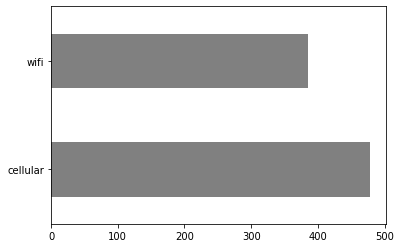

In [64]:
df.agentconnectiontype.value_counts().plot(kind='barh', color='grey');

This feature may be of use. Cellular data implies public connection. Wifi is connected to your home router. Hence the possibility of fraud from cellular may be high.

### **Screen hash**

In [65]:
df.screen_hash.nunique()

115

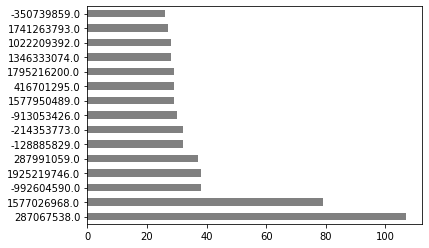

In [66]:
df.screen_hash.value_counts().nlargest(15).plot(kind='barh', color='grey');

Not sure how to correlate this to fraud. Screenhash is simply a numeric representation of what a screen looked like at that event (point in time).

### **device for user**

In [67]:
df['device for user'].nunique()

2

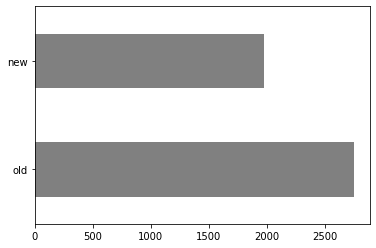

In [68]:
df['device for user'].value_counts().plot(kind='barh', color='grey');

### **receiver**

In [69]:
df.reciever.nunique()

2

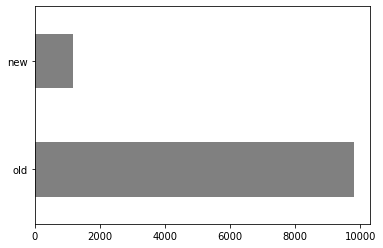

In [70]:
df.reciever.value_counts().plot(kind='barh', color='grey');

Receiver? 

### **password change**

In [71]:
df['password change'].nunique()

1

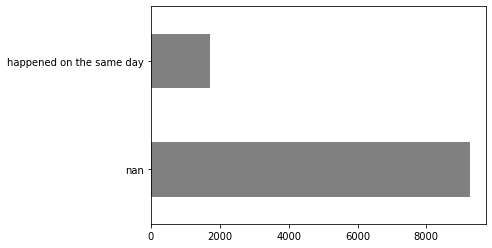

In [72]:
df['password change'].value_counts(dropna=False).plot(kind='barh', color='grey');

### **Fast change of IP**

In [73]:
df['fast change of ip'].nunique()

1

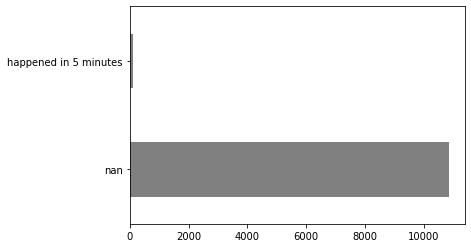

In [74]:
df['fast change of ip'].value_counts(dropna=False).plot(kind='barh', color='grey');

### **ip not equal to previous**

In [75]:
df['ip not equal to previous'].nunique()

1

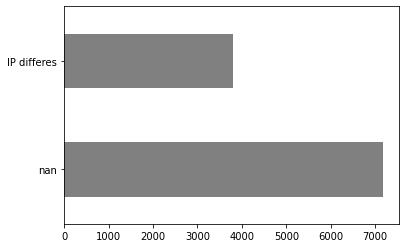

In [76]:
df['ip not equal to previous'].value_counts(dropna=False).plot(kind='barh', color='grey');

## END


